In [1]:
from pathlib import Path
import json
import csv
import pandas as pd
import numpy as np
import matplotlib

In [2]:
# global flags
generate_graphs = True

In [3]:
# font settings
if generate_graphs:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = True

# Data Gathering
 - Gather json files into csv files

In [4]:
def gather_json(directory, typ):
    with (directory / 'data.csv').open('w') as csvfile:
        wr = csv.writer(csvfile, delimiter=',')
        wr.writerow(['benchmark', 'type', 'key', 'value'])

        for bench in directory.glob("*.json"):
            benchname = bench.stem
            if 'linear-algebra' in str(bench):
                benchname = bench.stem.split('-')[2]
            try:
                for key, value in json.load(bench.open()).items():
                    wr.writerow([benchname, typ, key, value])
            except json.JSONDecodeError as e:
                print(f"{bench} decode error: {e}")

In [5]:
# polybench standard
gather_json(Path("../results/standard/hls/"), 'hls')
gather_json(Path("../results/standard/futil/"), 'futil')
gather_json(Path("../results/standard/futil-latency/"), 'futil')

# polybench unrolled
gather_json(Path("../results/unrolled/hls/"), 'hls-unrolled')
gather_json(Path("../results/unrolled/futil/"), 'futil-unrolled')
gather_json(Path("../results/unrolled/futil-latency/"), 'futil-unrolled')

# systolic
gather_json(Path("../results/systolic/hls/"), 'systolic-hls')
gather_json(Path("../results/systolic/futil/"), 'systolic-futil')
gather_json(Path("../results/systolic/futil-no-static/"), 'systolic-futil-no-static')
# gather_json(Path("../results/systolic/futil-no-opts/"), 'systolic-futil-no-opts')
gather_json(Path("../results/systolic/futil-latency/"), 'systolic-futil')
gather_json(Path("../results/systolic/futil-no-static-latency/"), 'systolic-futil-no-static')

# latency sensitive
gather_json(Path("../results/latency-sensitive/no-static-timing/"), 'no-static-timing')
gather_json(Path("../results/latency-sensitive/with-static-timing/"), 'with-static-timing')

# optimizations
gather_json(Path("../results/opts/all/"), 'all')
gather_json(Path("../results/opts/minimize-regs/"), 'minimize-regs')
gather_json(Path("../results/opts/resource-sharing/"), 'resource-sharing')
gather_json(Path("../results/opts/none/"), 'none')
gather_json(Path("../results/opts/all-unrolled/"), 'all-unrolled')
gather_json(Path("../results/opts/minimize-regs-unrolled/"), 'minimize-regs-unrolled')
gather_json(Path("../results/opts/resource-sharing-unrolled/"), 'resource-sharing-unrolled')
gather_json(Path("../results/opts/none-unrolled/"), 'none-unrolled')

# Pandas data processing

## Gather Data + Cleanup
 - Throwaway keys irrelevant for the figures and do renaming

In [6]:
def cleanup(df, rename, include):
    df = df.copy()
    # rename
    for (key_name, key), v in rename.items():
        df.loc[df[key_name] == key, key_name] = v

    # only keep things in include
    return df[df['key'].isin(include)].reset_index(drop=True)

polybench_rename = {
    ('benchmark', '2mm'): '2mm',
    ('benchmark', '3mm'): '3mm',
    ('benchmark', 'atax'): 'ata',
    ('benchmark', 'doitgen'): 'dtg',
    ('benchmark', 'gemm'): 'gmm',
    ('benchmark', 'gemver'): 'gmv',
    ('benchmark', 'gesummv'): 'gev',
    ('benchmark', 'gramschmidt'): "gmt",
    ('benchmark', 'mvt'): "mvt",
    ('benchmark', 'syr2k'): "s2k",
    ('benchmark', 'syrk'): "sk",
    ('benchmark', 'bicg'): "bcg",
    ('benchmark', 'cholesky'): "cky",
    ('benchmark', 'durbin'): "dbn",
    ('benchmark', 'lu'): "lu",
    ('benchmark', 'ludcmp'): "lcp",
    ('benchmark', 'symm'): "sym",
    ('benchmark', 'trisolv'): "tsv",
    ('benchmark', 'trmm'): "trm"
}

# polybench data
standard_hls = pd.read_csv("../results/standard/hls/data.csv")
standard_futil = pd.read_csv("../results/standard/futil/data.csv")
standard_futil_lat = pd.read_csv("../results/standard/futil-latency/data.csv")
unrolled_hls = pd.read_csv("../results/unrolled/hls/data.csv")
unrolled_futil = pd.read_csv("../results/unrolled/futil/data.csv")
unrolled_futil_lat = pd.read_csv("../results/unrolled/futil-latency/data.csv")
polybench_raw = standard_hls.append(standard_futil).append(standard_futil_lat).append(unrolled_hls).append(unrolled_futil).append(unrolled_futil_lat).reset_index(drop=True)
polybench = cleanup(polybench_raw, {
    ('key', 'avg_latency'): 'latency',
    **polybench_rename
}, ['dsp', 'lut', 'latency'])

# systolic data
hls = pd.read_csv("../results/systolic/hls/data.csv")
futil = pd.read_csv("../results/systolic/futil/data.csv")
futil_dyn = pd.read_csv("../results/systolic/futil-no-static/data.csv")
# futil_no_opts = pd.read_csv("../results/systolic/futil-no-opts/data.csv")
futil_lat = pd.read_csv("../results/systolic/futil-latency/data.csv")
futil_dyn_lat = pd.read_csv("../results/systolic/futil-no-static-latency/data.csv")
systolic_raw = hls.append(futil).append(futil_dyn).append(futil_lat).append(futil_dyn_lat).reset_index(drop=True)
systolic = cleanup(systolic_raw, {
    ('key', 'avg_latency'): 'latency',
    ('benchmark', 'gemm2'): '2 x 2',
    ('benchmark', 'gemm4'): '4 x 4',
    ('benchmark', 'gemm6'): '6 x 6',
    ('benchmark', 'gemm8'): '8 x 8',
}, ['dsp', 'lut', 'latency'])

# latency insensitive data
with_static_timing = pd.read_csv('../results/latency-sensitive/with-static-timing/data.csv')
no_static_timing = pd.read_csv('../results/latency-sensitive/no-static-timing/data.csv')
latency_sensitive_raw = with_static_timing.append(no_static_timing).reset_index(drop=True)
latency_sensitive = cleanup(latency_sensitive_raw, polybench_rename, ['latency'])

# opts
opts_all = pd.read_csv('../results/opts/all/data.csv')
opts_mr = pd.read_csv('../results/opts/minimize-regs/data.csv')
opts_rs = pd.read_csv('../results/opts/resource-sharing/data.csv')
opts_none = pd.read_csv('../results/opts/none/data.csv')
opts_std = opts_all.append(opts_mr).append(opts_rs).append(opts_none)
opts_all = pd.read_csv('../results/opts/all-unrolled/data.csv')
opts_mr = pd.read_csv('../results/opts/minimize-regs-unrolled/data.csv')
opts_rs = pd.read_csv('../results/opts/resource-sharing-unrolled/data.csv')
opts_none = pd.read_csv('../results/opts/none-unrolled/data.csv')
opts_ur = opts_all.append(opts_mr).append(opts_rs).append(opts_none)
opts_raw = opts_std.append(opts_ur).reset_index(drop=True)
opts = cleanup(opts_raw, polybench_rename, ['lut', 'dsp', 'meet_timing', 'registers', 'muxes', 'clb_registers',
       'carry8', 'f7_muxes', 'f8_muxes', 'f9_muxes', 'clb', 'cell_lut1',
       'cell_lut2', 'cell_lut3', 'cell_lut4', 'cell_lut5', 'cell_lut6',
       'cell_fdre'])

## Calculate norms 

In [7]:
def match(df, benchmark, typ):
    return df[(df['benchmark'] == benchmark) & (df['type'] == typ)]

def _row_math(df, top_key, bot_key, name, op):
    df = df.copy()
    for bench in df['benchmark'].unique():
        norm = match(df, bench, top_key).copy()
        top = match(df, bench, top_key)['value']
        bot = match(df, bench, bot_key)['value']
        if len(top.values) == len(bot.values):
            norm['value'] = op(top.values,bot.values)
            norm['type'] = name
            df = df.append(norm)
    return df

def norm(df, top_key, bot_key, name):
    return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)

        
# polybench = norm(polybench, 'futil', 'hls', 'norm')
# polybench = norm(polybench, 'futil-unrolled', 'hls-unrolled', 'norm-unrolled')
polybench = norm(polybench, 'hls', 'futil', 'norm')
polybench = norm(polybench, 'hls-unrolled', 'futil-unrolled', 'norm-unrolled')

# latency_sensitive = norm(latency_sensitive, 'with-static-timing', 'no-static-timing', 'norm')
latency_sensitive = norm(latency_sensitive, 'no-static-timing', 'with-static-timing', 'norm')

# opts = norm(opts, 'minimize-regs', 'none', 'minimize-regs-norm')
# opts = norm(opts, 'resource-sharing', 'none', 'resource-sharing-norm')
# opts = norm(opts, 'all', 'none', 'all-norm')
opts = norm(opts, 'none', 'minimize-regs', 'minimize-regs-norm')
opts = norm(opts, 'none', 'resource-sharing', 'resource-sharing-norm')
opts = norm(opts, 'none', 'all', 'all-norm')

systolic = norm(systolic, 'systolic-hls', 'systolic-futil', 'speedup')
systolic = norm(systolic, 'systolic-futil', 'systolic-hls', 'slowdown')
systolic = norm(systolic, 'systolic-futil-no-static', 'systolic-futil', 'static-speedup')
systolic = norm(systolic, 'systolic-futil', 'systolic-futil-no-static', 'static-slowdown')

# opts = _row_math(opts, 'none', 'minimize-regs', 'mr-diff', lambda a, b: b - a)
# opts = _row_math(opts, 'none', 'resource-sharing', 'rs-diff', lambda a, b: b - a)
# opts = _row_math(opts, 'none', 'all', 'all-diff', lambda a, b: b - a)

<ipython-input-7-8e0978688c34>:17: RuntimeWarning: invalid value encountered in true_divide
  return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)
<ipython-input-7-8e0978688c34>:17: RuntimeWarning: divide by zero encountered in true_divide
  return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)


## Dataframe formatting
 - Transition from long-form to short-form data by using `pivot`.
 - Reorder table so that unrolled benchmarks are grouped at the beginning

In [8]:
def pivot_and_order(df, order):
    df = df.pivot(index=['benchmark', 'type'], columns='key', values='value').reset_index()
    df['benchmark'] = pd.Categorical(df['benchmark'], order)
    return df

polybench_order = [
    '2mm', '3mm', 'ata',
    'dtg', 'gmm', 'gmv',
    'gev', "gmt", "mvt",
    "s2k", "sk", "bcg",
    "cky", "dbn", "lu",
    "lcp", "sym", "tsv",
    "trm"
]

polybench = pivot_and_order(polybench, polybench_order)

systolic = pivot_and_order(systolic, [
    '2 x 2',
    '4 x 4',
    '6 x 6',
    '8 x 8'
])

latency_sensitive = pivot_and_order(latency_sensitive, polybench_order)
opts = pivot_and_order(opts, polybench_order)

## Helpers

In [9]:
def apply_legend(df, name, legend):
    df = df.copy()
    df = df[df[name].isin(list(legend.keys()))]
    df[name] = df[name].apply(lambda x: legend[x])
    return df

# Graph Generation

## 5a. Systolic Array Normalized cycle counts

In [10]:
# figure 5 font settings
fig_fontsize=22

Geomean Futil Speedup 4.604307278517825
Geomean Static Speedup 1.8757033349332726


array([1.72972973, 1.88235294, 1.92907801, 1.97073171])

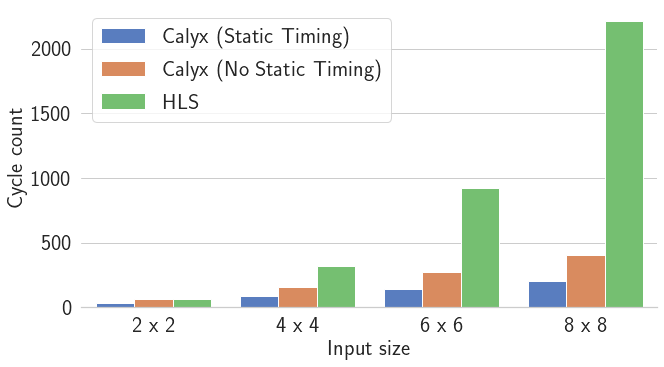

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'systolic-futil': 'Calyx (Static Timing)',
    'systolic-futil-no-static': 'Calyx (No Static Timing)',
    'systolic-hls': 'HLS',
}
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=apply_legend(systolic, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    hue_order=legend.values(),
    log=False
)
g.despine(left=True)
g.set_ylabels("Cycle count", fontsize=fig_fontsize)
g.set_xlabels("Input size", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize)
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(fig_fontsize) # I hate this, but otherwise the axes would be wrong
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "{:.0f}".format(x)))
g.axes[0,0].legend(loc='upper left', fontsize=fig_fontsize).set_title('')
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('systolic-lat.pdf')
    
futil_speedup = systolic[systolic['type'] == 'systolic-hls']['latency'].values / systolic[systolic['type'] == 'systolic-futil']['latency'].values
static_speedup = systolic[systolic['type'] == 'systolic-futil-no-static']['latency'].values / systolic[systolic['type'] == 'systolic-futil']['latency'].values
from scipy import stats
print('Geomean Futil Speedup', stats.gmean(futil_speedup))
print('Geomean Static Speedup', stats.gmean(static_speedup))
static_speedup

## 5b. Systolic Array Normalized LUT usage

Geomean Futil Slowdown 1.1108518882478782
Geomean Static Speedup 1.0932331181567236


array([0.88011283, 1.12921779, 1.16044029, 1.23854632])

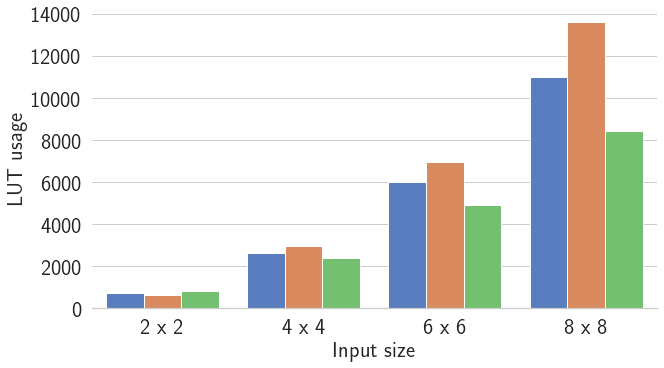

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'systolic-futil': 'Calyx (Static Timing)',
    'systolic-futil-no-static': 'Calyx (No Static Timing)',
    'systolic-hls': 'HLS',
}
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=apply_legend(systolic, 'type', legend),
    kind="bar", 
    palette="muted",
    hue_order=legend.values(),
    legend=False,
)
g.despine(left=True)
g.set_ylabels("LUT usage", fontsize=fig_fontsize)
g.set_xlabels("Input size", fontsize=fig_fontsize)
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(fig_fontsize) # I hate this, but otherwise the axes would be wrong
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "{:.0f}".format(x)))
g.set_xticklabels(fontsize=fig_fontsize)
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('systolic-lut.pdf')
    
futil_speedup = systolic[systolic['type'] == 'systolic-futil']['lut'].values / systolic[systolic['type'] == 'systolic-hls']['lut'].values
static_speedup = systolic[systolic['type'] == 'systolic-futil-no-static']['lut'].values / systolic[systolic['type'] == 'systolic-futil']['lut'].values
from scipy import stats
print('Geomean Futil Slowdown', stats.gmean(futil_speedup))
print('Geomean Static Speedup', stats.gmean(static_speedup))
static_speedup

<ipython-input-13-fbac52a2a1cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lut-1'] = df['latency']-1


1.0932331181567236

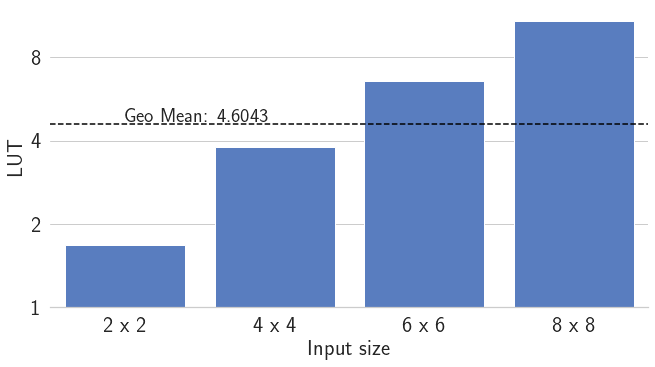

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = systolic[systolic["type"] == "speedup"]
df['lut-1'] = df['latency']-1

g = sns.catplot(
    x="benchmark", 
    y="lut-1", 
    hue="type", 
    data=df,
    kind="bar", 
    palette="muted",
    legend=False,
    bottom=1
)

g.despine(left=True)
g.set_ylabels("LUT", fontsize=fig_fontsize)
g.set_xlabels("Input size", fontsize=fig_fontsize)
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(fig_fontsize) # I hate this, but otherwise the axes would be wrong
g.set_xticklabels(fontsize=fig_fontsize)
g.fig.set_size_inches(10,5)

plt.yscale('log', base=2)
# plt.yticks(np.arange(0, 2, 0.2), fontsize=fig_fontsize)
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{x:.9g}"))
# plt.ylim([0.7, 1.3])

from scipy import stats
gmean = stats.gmean(df['lut-1']+1)
# print("Gmean: ", gmean)
g.axes[0,0].axhline(gmean, color="black", linestyle="dashed")
plt.text(0, gmean+0.05, f"Geo Mean: {gmean:.4f}", fontsize=20)

stats.gmean(systolic[systolic['type'].isin(['static-speedup'])]['lut'].values)

## 6a. Cycle counts normalized to Vivado HLS

In [14]:
# figure 6 font settings
fig_fontsize=27
legend_fontsize=24

<ipython-input-15-6ecc49ec9b09>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency-1'] = df['latency'] - 1


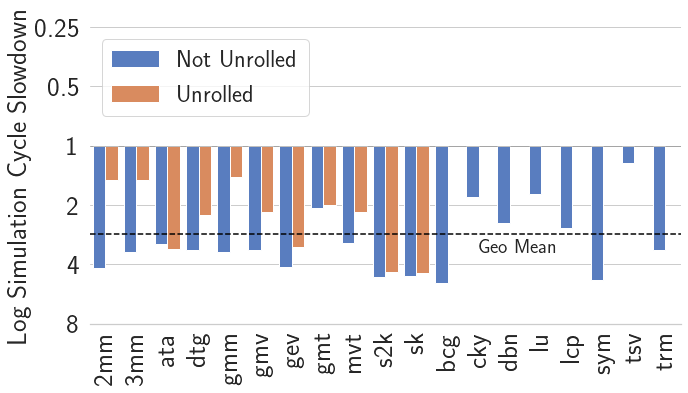

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'Not Unrolled',
    'norm-unrolled': 'Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
df['latency-1'] = df['latency'] - 1
g = sns.catplot(
    x="benchmark",
    y="latency-1",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
    bottom=1
)
g.despine(left=True)
g.set_ylabels("Log Simulation Cycle Slowdown", fontsize=fig_fontsize)
g.set_xlabels("", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize, rotation=90)
g.axes[0,0].legend(loc='upper left', fontsize=legend_fontsize).set_title('')
g.fig.set_size_inches(10,5)
g.axes[0,0].axhline(1, color="gray", linewidth=0.5)

plt.yscale('log', base=2)
plt.ylim([1/8, 4])
plt.yticks(fontsize=fig_fontsize)
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{1/x:.9g}"))

from scipy import stats
gmean = stats.gmean(df['latency'])
# print("Gmean: ", gmean)
g.axes[0,0].axhline(gmean, color="black", linestyle="dashed", label="Geo Mean")
plt.text(12, gmean-0.07, "Geo Mean", fontsize=20)

if generate_graphs:
    g.savefig('unrolled-lat-sen-cycles.pdf')

# norm = df[df['type'] == 'norm']['latency'].values
# norm_ur = df[df['type'] == 'norm-unrolled']['latency'].values
# print('Geometric mean (rolled)', stats.gmean(norm))
# print('Geometric mean (unrolled)', stats.gmean(norm_ur))
# print('rolled', norm)
# print('unrolled', norm_ur)

## 6b. LUT usage normalized to Vivado HLS

<ipython-input-16-1d001f994d00>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lut-1'] = df['lut'] - 1


Geometric mean (rolled) 0.8024789426210192
Geometric mean (unrolled) 0.454014374585063
rolled [0.23156597 1.325      0.47031611 1.05144695 7.11267606 1.31773399
 1.42692308 0.32390746 0.26027961 1.04050309 0.56336842 1.32062966
 1.66086957 0.49361382 0.27069351 0.40776081 0.8206278  1.0224359
 1.52      ]
unrolled [0.47494259 0.49374603 0.53448276 0.1933287  0.45507763 0.443888
 0.98753192 0.58601847 0.53038024 0.26464924 0.42492428]


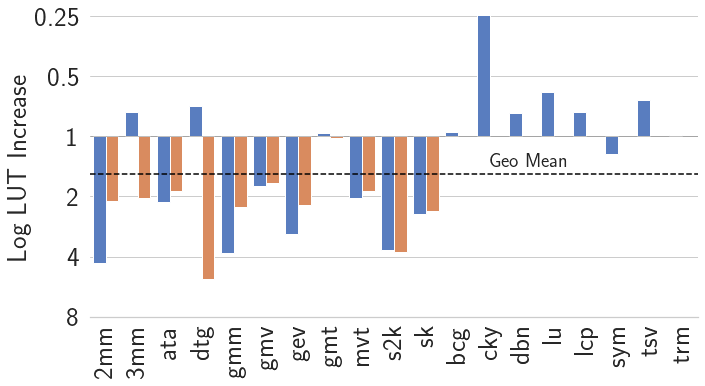

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'Not Unrolled',
    'norm-unrolled': 'Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
df['lut-1'] = df['lut'] - 1
g = sns.catplot(
    x="benchmark",
    y="lut-1",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
    bottom=1
)
g.despine(left=True)
g.set_ylabels("Log LUT Increase", fontsize=fig_fontsize)
g.set_xlabels("", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize, rotation=90)
# g.axes[0,0].legend(loc='upper left', fontsize=legend_fontsize).set_title('')
g.axes[0,0].axhline(1, color="gray", linewidth=0.5)
g.fig.set_size_inches(10,5)

plt.yscale('log', base=2)
plt.yticks(fontsize=fig_fontsize)
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{1/x:.3g}"))
plt.ylim([1/8, 4])

from scipy import stats
gmean = stats.gmean(df['lut'])
# print("Gmean: ", gmean)
g.axes[0,0].axhline(gmean, color="black", linestyle="dashed", label="Geo Mean")
plt.text(12, gmean+0.05, "Geo Mean", fontsize=20)

if generate_graphs:
    g.savefig('unrolled-lat-sen-lut.pdf')
    
from scipy import stats
norm = df[df['type'] == 'norm']['lut'].values
norm_ur = df[df['type'] == 'norm-unrolled']['lut'].values
print('Geometric mean (rolled)', stats.gmean(norm))
print('Geometric mean (unrolled)', stats.gmean(norm_ur))
print('rolled', norm)
print('unrolled', norm_ur)

# Optimizations

In [17]:
# fontsize
# fig_fontsize=22

Resorce Sharing Mean 0.9938442635870974
Register Sharing 1 - Mean -0.05441534937610526


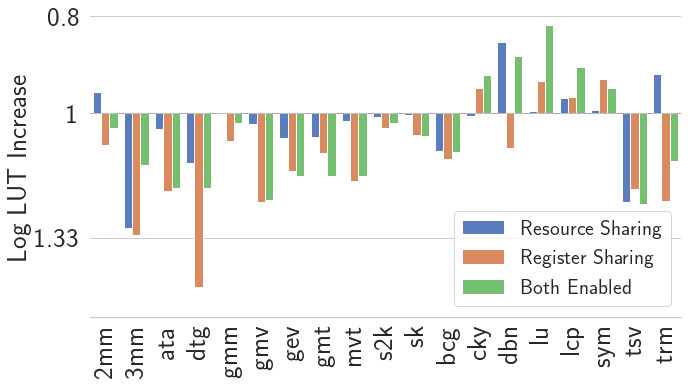

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'resource-sharing-norm': 'Resource Sharing',
    'minimize-regs-norm': 'Register Sharing',
    'all-norm': 'Both Enabled'
}

opts['lut-1'] = opts['lut'] - 1

g = sns.catplot(
    x="benchmark", 
    y="lut-1",
    hue="type",
    data=apply_legend(opts, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    hue_order=legend.values(),
    bottom=1
)
g.despine(left=True)
g.set_ylabels("Log LUT Increase", fontsize=fig_fontsize)
g.set_xlabels("", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize, rotation=90)
g.axes[0,0].legend(loc='lower right', fontsize=fig_fontsize-6).set_title('')
g.axes[0,0].axhline(1, color="gray", linewidth=0.5)
g.fig.set_size_inches(10,5)

plt.yscale('log', base=2)
plt.yticks([0.5, 0.75, 1, 1.25, 1.5], fontsize=fig_fontsize)
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{1/x:.3g}"))
plt.ylim([5/8, 1.25])

if generate_graphs:
    g.savefig('norm-opts-lut.pdf', dpi=400)
    
df = apply_legend(opts, 'type', legend)
from scipy import stats
print('Resorce Sharing Mean', stats.gmean(df[df['type'] == 'Resource Sharing']['clb'].values))
print('Register Sharing 1 - Mean', 1 - stats.gmean(df[df['type'] == 'Register Sharing']['clb'].values))

Gmean:  1.1388410892006589
Register Sharing 1 - Mean -0.13884108920065885


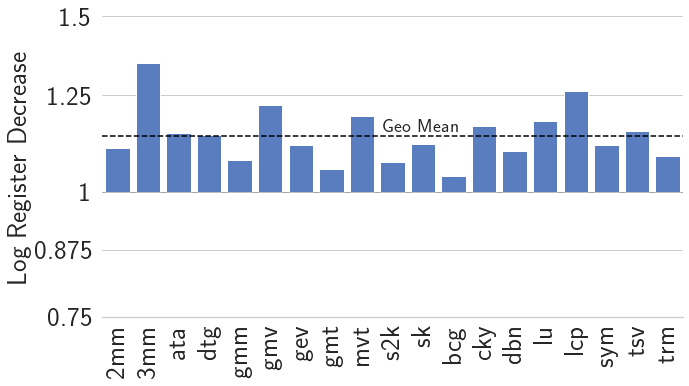

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'minimize-regs-norm': 'Registers',
}

df = opts
df['registers-1'] = df['registers'] - 1
g = sns.catplot(
    x="benchmark", 
    y="registers-1",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    hue_order=legend.values(),
    bottom=1
)
g.despine(left=True)
g.set_ylabels("Log Register Decrease", fontsize=fig_fontsize)
g.set_xlabels("")
g.set_xticklabels(fontsize=fig_fontsize, rotation=90)
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(fig_fontsize) # I hate this, but otherwise the axes would be wrong
# g.axes[0,0].legend(loc='lower right').set_title('')
g.fig.set_size_inches(10,5)

plt.yscale('log', base=2)
plt.yticks([0.5, 0.75, 7/8, 1, 1.25, 1.5], fontsize=fig_fontsize)
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{x:.9g}"))
plt.ylim([0.75, 3/2])

from scipy import stats
gmean = stats.gmean(df[df['type'] == 'minimize-regs-norm']['registers'])
print("Gmean: ", gmean)
g.axes[0,0].axhline(gmean, color="black", linestyle="dashed", label="Geo Mean")
plt.text(8.7, gmean+0.01, "Geo Mean", fontsize=19)

g.axes[0,0].axhline(1, color="gray", linewidth=0.5)
if generate_graphs:
    g.savefig('norm-opts-regs.pdf', dpi=400)
    
df = apply_legend(opts, 'type', legend)
from scipy import stats
print('Register Sharing 1 - Mean', 1 - stats.gmean(df[df['type'] == 'Registers']['registers'].values))

# Cycle counts normalized to latency-insensitive design 

<ipython-input-20-eb622194c195>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency-1'] = df['latency'] - 1


Gmean:  1.4258231520054718


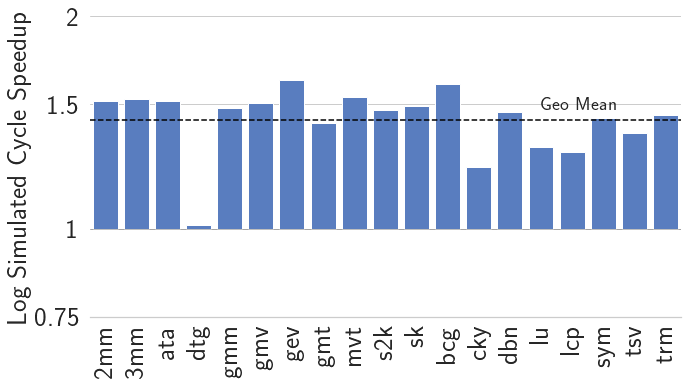

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = latency_sensitive[latency_sensitive['type'] == 'norm']
df['latency-1'] = df['latency'] - 1
g = sns.catplot(
    x="benchmark", 
    y="latency-1",
    hue="type",
    data=df,
    kind="bar", 
    palette="muted",
    legend=False,
    bottom=1
)
g.despine(left=True)
g.set_ylabels("Log Simulated Cycle Speedup", fontsize=fig_fontsize)
g.set_xlabels("", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize, rotation=90)
g.axes[0,0].axhline(1, color="gray", linewidth=0.5)
g.fig.set_size_inches(10,5)

plt.yscale('log', base=2)
plt.yticks([0.5, 0.75, 1, 1.5, 2], fontsize=fig_fontsize)
g.axes[0,0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{x:.9g}"))
plt.ylim([0.75, 2])

from scipy import stats
gmean = stats.gmean(df['latency'])
print("Gmean: ", gmean)
g.axes[0,0].axhline(gmean, color="black", linestyle="dashed", label="Geo Mean")
plt.text(14, gmean+0.05, "Geo Mean", fontsize=19)

if generate_graphs:
    g.savefig('norm-lat-sen-insen.pdf', dpi=400)
    
# from scipy import stats
# speedup = (df[df['type'] == 'no-static-timing']['latency'].values / df[df['type'] == 'with-static-timing']['latency'].values)
# print('Geometric mean', stats.gmean(speedup - 1))
# speedup - 1